print("hello")

In [ ]:
print("hello")

hello


For this lab, let's us the following libraries:

- [`torch`](https://pytorch.org/): The core library for building and training neural network models in this project, including the implementation of Self-Attention mechanisms and Positional Encodings.
- [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html): These PyTorch submodules are used to define the neural network layers and apply functions such as activations, which are essential in building the model architecture.
- [`Levenshtein`](https://pypi.org/project/python-Levenshtein/): This library is used for calculating the Levenshtein distance, which can be useful for evaluating model performance in tasks like text generation or translation by measuring the difference between the predicted and actual text sequences.
- [`get_tokenizer`](https://pytorch.org/text/stable/data_utils.html), [`build_vocab_from_iterator`](https://pytorch.org/text/stable/vocab.html) from `torchtext`: These functions are crucial for preprocessing text data, including tokenizing text into words or subwords and building a vocabulary from the dataset, which are foundational steps in preparing data for NLP models.


In [ ]:
# Install packages
! pip install Levenshtein
#! pip install matplotlib
!pip install torch==2.3.0 torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 835.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import sys
import time
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

from Levenshtein import distance
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
# Device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split = 'train'

# Training parameters
learning_rate = 3e-4
batch_size = 64
max_iters = 5000              # Maximum training iterations
eval_interval = 200           # Evaluate model every 'eval_interval' iterations in the training loop
eval_iters = 100              # When evaluating, approximate loss using 'eval_iters' batches

# Architecture parameters
max_vocab_size = 256          # Maximum vocabulary size
vocab_size = max_vocab_size   # Real vocabulary size (e.g. BPE has a variable length, so it can be less than 'max_vocab_size')
block_size = 16               # Context length for predictions
n_embd = 32                   # Embedding size
num_heads = 2                 # Number of head in multi-headed attention
n_layer = 2                   # Number of Blocks
ff_scale_factor = 4           # Note: The '4' magic number is from the paper: In equation 2 uses d_model=512, but d_ff=2048
dropout = 0.0                 # Normalization using dropout# 10.788929 M parameters

head_size = n_embd // num_heads
assert (num_heads * head_size) == n_embd

In [ ]:
def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [ ]:
dictionary = {
    'le': 'the'
    , 'chat': 'cat'
    , 'est': 'is'
    , 'sous': 'under'
    , 'la': 'the'
    , 'table': 'table'
}

In [ ]:
# Create and sort the input vocabulary from the dictionary's keys
vocabulary_in = sorted(list(set(dictionary.keys())))
# Display the size and the sorted vocabulary for the input language
print(f"Vocabulary input ({len(vocabulary_in)}): {vocabulary_in}")

# Create and sort the output vocabulary from the dictionary's values
vocabulary_out = sorted(list(set(dictionary.values())))
# Display the size and the sorted vocabulary for the output language
print(f"Vocabulary output ({len(vocabulary_out)}): {vocabulary_out}")

Vocabulary input (6): ['chat', 'est', 'la', 'le', 'sous', 'table']
Vocabulary output (5): ['cat', 'is', 'table', 'the', 'under']


 - The tokenize function is responsible for breaking down a sentence into individual words.
 - The translate function uses this tokenize function to split the input sentence and then translates each word according to the dictionary. The translated words are concatenated to form the output sentence.

In [ ]:
# Function to convert a list of vocabulary words into one-hot encoded vectors
def encode_one_hot(vocabulary):
    vocabulary_size = len(vocabulary)  # Get the size of the vocabulary
    one_hot = dict()  # Initialize a dictionary to hold our one-hot encodings
    LEN = len(vocabulary)  # The length of each one-hot encoded vector will be equal to the vocabulary size

    # Iterate over the vocabulary to create a one-hot encoded vector for each word
    for i, key in enumerate(vocabulary):
        one_hot_vector = torch.zeros(LEN)  # Start with a vector of zeros
        one_hot_vector[i] = 1  # Set the i-th position to 1 for the current word
        one_hot[key] = one_hot_vector  # Map the word to its one-hot encoded vector
        print(f"{key}\t: {one_hot[key]}")  # Print each word and its encoded vector

    return one_hot  # Return the dictionary of words and their one-hot encoded vectors

In [ ]:
# Apply the one-hot encoding function to the input vocabulary and store the result
one_hot_in = encode_one_hot(vocabulary_in)

chat	: tensor([1., 0., 0., 0., 0., 0.])
est	: tensor([0., 1., 0., 0., 0., 0.])
la	: tensor([0., 0., 1., 0., 0., 0.])
le	: tensor([0., 0., 0., 1., 0., 0.])
sous	: tensor([0., 0., 0., 0., 1., 0.])
table	: tensor([0., 0., 0., 0., 0., 1.])


In [ ]:
# Iterate over the one-hot encoded input vocabulary and print each vector
# This visualizes the one-hot representation for each word in the input vocabulary
for k, v in one_hot_in.items():
    print(f"E_{{ {k} }} = " , v)

E_{ chat } =  tensor([1., 0., 0., 0., 0., 0.])
E_{ est } =  tensor([0., 1., 0., 0., 0., 0.])
E_{ la } =  tensor([0., 0., 1., 0., 0., 0.])
E_{ le } =  tensor([0., 0., 0., 1., 0., 0.])
E_{ sous } =  tensor([0., 0., 0., 0., 1., 0.])
E_{ table } =  tensor([0., 0., 0., 0., 0., 1.])


In [ ]:
# Apply the one-hot encoding function to the output vocabulary and store the result
# This time we're encoding the target language vocabulary
one_hot_out = encode_one_hot(vocabulary_out)

cat	: tensor([1., 0., 0., 0., 0.])
is	: tensor([0., 1., 0., 0., 0.])
table	: tensor([0., 0., 1., 0., 0.])
the	: tensor([0., 0., 0., 1., 0.])
under	: tensor([0., 0., 0., 0., 1.])


The decode_one_hot function is designed to decode a one-hot encoded vector back into the corresponding token (word). It does this by finding the token whose one-hot representation has the highest cosine similarity with the given vector, which is effectively just the dot product due to the nature of one-hot vectors.

In [ ]:
def decode_one_hot(one_hot, vector):
    """
    Decode a one-hot encoded vector to find the best matching token in the vocabulary.
    """
    best_key, best_cosine_sim = None, 0
    for k, v in one_hot.items():  # Iterate over the one-hot encoded vocabulary
        cosine_sim = torch.dot(vector, v)  # Calculate dot product (cosine similarity)
        if cosine_sim > best_cosine_sim:  # If this is the best similarity we've found
            best_cosine_sim, best_key = cosine_sim, k  # Update the best similarity and token
    return best_key  # Return the token corresponding to the one-hot vector

In [ ]:
def translate(sentence):
    """
    Translate a sentence using matrix multiplication, treating the dictionaries as matrices.
    """
    sentence_out = ''  # Initialize the output sentence
    for token_in in tokenize(sentence):  # Tokenize the input sentence
        q = one_hot_in[token_in]  # Find the one-hot vector for the token
        out = q @ K.T @ V  # Multiply with the input and output matrices to find the translation
        token_out = decode_one_hot(one_hot_out, out)  # Decode the output one-hot vector to a token
        sentence_out += token_out + ' '  # Append the translated token to the output sentence
    return sentence_out.strip()  # Return the translated sentence

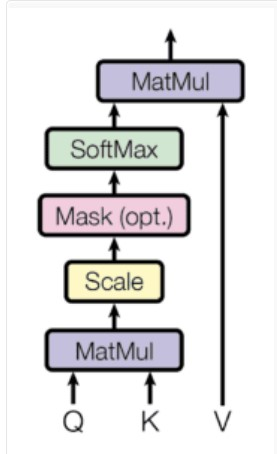

The attention mechanism allows the model to focus on relevant parts of a sentence, helping it understand the context of words.

Key Steps in the Attention Mechanism
Input Processing:

An input sentence (e.g., "The bank of the river was flooded") is fed into the model.
Each word in the sentence is tokenized and converted into an embedding vector.
For each word (or token), three vectors are created by multiplying the embedding vector with three learned matrices:

Query vector (Q)

Key vector (K)

Value vector (V)

Generating Attention Scores:

To determine how much attention each word should pay to other words, the model:
Takes the query vector of the current word (e.g., "bank").
Multiplies it with the key vectors of all other words in the sentence using a dot product to compute attention scores.
A high attention score indicates that a word is highly relevant in the given context (e.g., "river" and "flooded" are highly relevant to "bank" in this example).

Using Attention Scores:

The attention scores are used to weigh the value vectors of the corresponding words.

The model combines the weighted value vectors to produce a context-aware representation of the current word.
For example, in the sentence "The bank of the river was flooded," the attention mechanism helps the model understand that "bank" refers to a river bank and not a financial institution, based on its relationship with "river" and "flooded."
Understanding Query, Key, and Value Matrices

Key Matrix (K):

Learns distinguishing features of each word, helping the model compare words and identify relevant ones.

Query Matrix (Q):

Learns parameters that, when multiplied with key vectors, produce meaningful attention scores.

Value Matrix (V):

Stores foundational knowledge about each word (e.g., meanings of "bank") and is refined by attention scores to produce context-aware word representations.

Purpose of the Attention Mechanism

The attention mechanism allows the model to create a context-aware representation of each word in the sentence.

This helps the model disambiguate words with multiple meanings (like "bank") by focusing on other relevant words in the context.

The final output is a set of refined, context-aware vectors for each word, which the model uses for further tasks like translation or text generation.

### Purpose of the Key Matrix (K)
The Key Matrix (W_K) is a learnable weight matrix in Transformer models.
It transforms token embeddings into key vectors, which help assess the relevance of each word in the sentence.

These key vectors are later used in the attention mechanism to compute attention scores.

### Mathematical Formulation

#### Token Embeddings (X):

Each word in the sentence is represented as an embedding vector (e.g., 3-dimensional).

#### Key Matrix (W_K):

A trainable matrix that enriches the embeddings. For example, we have 3×3 matrix, containing learnable weights.

If word embeddings have 3 values per word, the Key Matrix must also have 3 input columns to properly transform these embeddings.
This ensures that the embedding size aligns with the key transformation.

#### Computing the Key Vector (K) for Each Token:

Multiply the token embedding X by W_K. For each word ( 1 x 3 embedding  we take dot product with W_K which is 3 x 3) to produce K (1 x 3).

The output K is still a 1×3 vector, but now enriched with additional information.

#### Constructing the Final Key Matrix (K)

We compute the key vector for each token in the sentence.
Then, all key vectors are stacked into a final key matrix. Final Key matrix would be of size vocabsize x 3.

Note: Dont confuse W_K with final key matrix K.





In [ ]:
class Head(nn.Module):
    """ Self attention head. This class implements a self-attention mechanism
        which is a key component of transformer-based neural network architectures. """

    def __init__(self):
        super().__init__()  # Initialize the superclass (nn.Module)
        # Embedding layer to convert input token indices to vectors of fixed size (n_embd)
        self.embedding = nn.Embedding(vocab_size, n_embd)

        # Linear layers to compute the queries, keys, and values from the embeddings

        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def attention(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        return embedded_x,k,q,v,w

    def forward(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        # Add weighted values
        out = w @ v
        return out

In [ ]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

In [ ]:
tokenizer = get_tokenizer("basic_english")  # Get a basic English tokenizer

In [ ]:
def yield_tokens(data_iter):
    """Yield list of tokens in the dataset."""
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown words

In [ ]:
def text_pipeline(x):
    """Converts a text string to a list of token indices."""
    return vocab(tokenizer(x))  # Tokenize the input and map each token to its index in the vocabulary

In [ ]:
vocab_size = len(vocab)  # Total number of tokens in the vocabulary
n_embd = 3  # Dimension of the embedding space

# Create the attention head with the integrated embedding layer
attention_head = Head()

In [ ]:
# Define the sentence to be tokenized and converted to indices
my_tokens = 'he painted the car red'
# Apply the text pipeline to the sentence to get token indices
input_data = torch.tensor(text_pipeline(my_tokens), dtype=torch.long)

# Print out the shape and the token indices tensor
print(input_data.shape)
print(input_data)

torch.Size([5])
tensor([12, 13, 15, 11, 14])


#### As you can see above, we have sentence size of 5 and we also have tokens indices for all the words. Next we pass this input data to attention(to see current alignment score) which first calculates embedding so after embedding, data would be transformed to 5 x 3 (vocab size x embedding size). In this step we use dot product.

#### Then we calculate key, query, and value once we get embedding from above steps for each word (5 x 3 matrix). Wk, Wq and Wv is of size 3 x 3. So when we take dot product data (5 x 3) with each weight, we will get 5 x 3 query, key and value. For example for key, each row contains respective key vector for first word. In this step as well we use dot product operation.

### Once we have all the components, we calculate alignment score w. We use Query(5 x 3) and Key (5 x 3) , compute dot product between these two with normalization to calculate alignment scores. Note we need to transpose K to match dimensions. So the output of alignment score would be 5 x 5 . This alignment tells us word to word relationship.

#### Then we normalize score using softmax function.

In [24]:
# Pass the tokenized input data through the embedding layer and the attention mechanism of the Head class
embedded_x, k, q, v, w = attention_head.attention(input_data)

# Print the size of the resulting embedded vector for verification
print(embedded_x.shape)  # Should show the shape as [number of tokens, embedding dimension]
print("embedded_x:", embedded_x)  # The actual embedded representations of the input tokens

torch.Size([5, 3])
embedded_x: tensor([[ 0.6470,  0.4262,  1.0773],
        [ 0.1049, -0.3996, -0.2484],
        [-0.0993, -0.2529, -0.4103],
        [ 0.4394, -0.1976,  0.1861],
        [ 0.1175, -0.3715,  1.9094]], grad_fn=<EmbeddingBackward0>)


In [25]:
# Print the shapes of the key, query, value, and attention weight matrices
# This helps verify the dimensions are as expected for the attention calculations
print("k:", k.shape)  # The shape of the keys tensor
print("q:", q.shape)  # The shape of the queries tensor
print("v:", v.shape)  # The shape of the values tensor
print("w:", w.shape)  # The shape of the attention weights tensor

k: torch.Size([5, 3])
q: torch.Size([5, 3])
v: torch.Size([5, 3])
w: torch.Size([5, 5])
